# Implementing Multi-Class Categorisation Learning

Using MNIST Hand-written digit data-set: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

import libraries

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Set the random seed for TensorFlow for consitency of results
tf.random.set_seed(1234)

MNIST Data - Reader Function https://www.kaggle.com/code/hojjatk/read-mnist-dataset

In [158]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)   

Functions to verfiy images

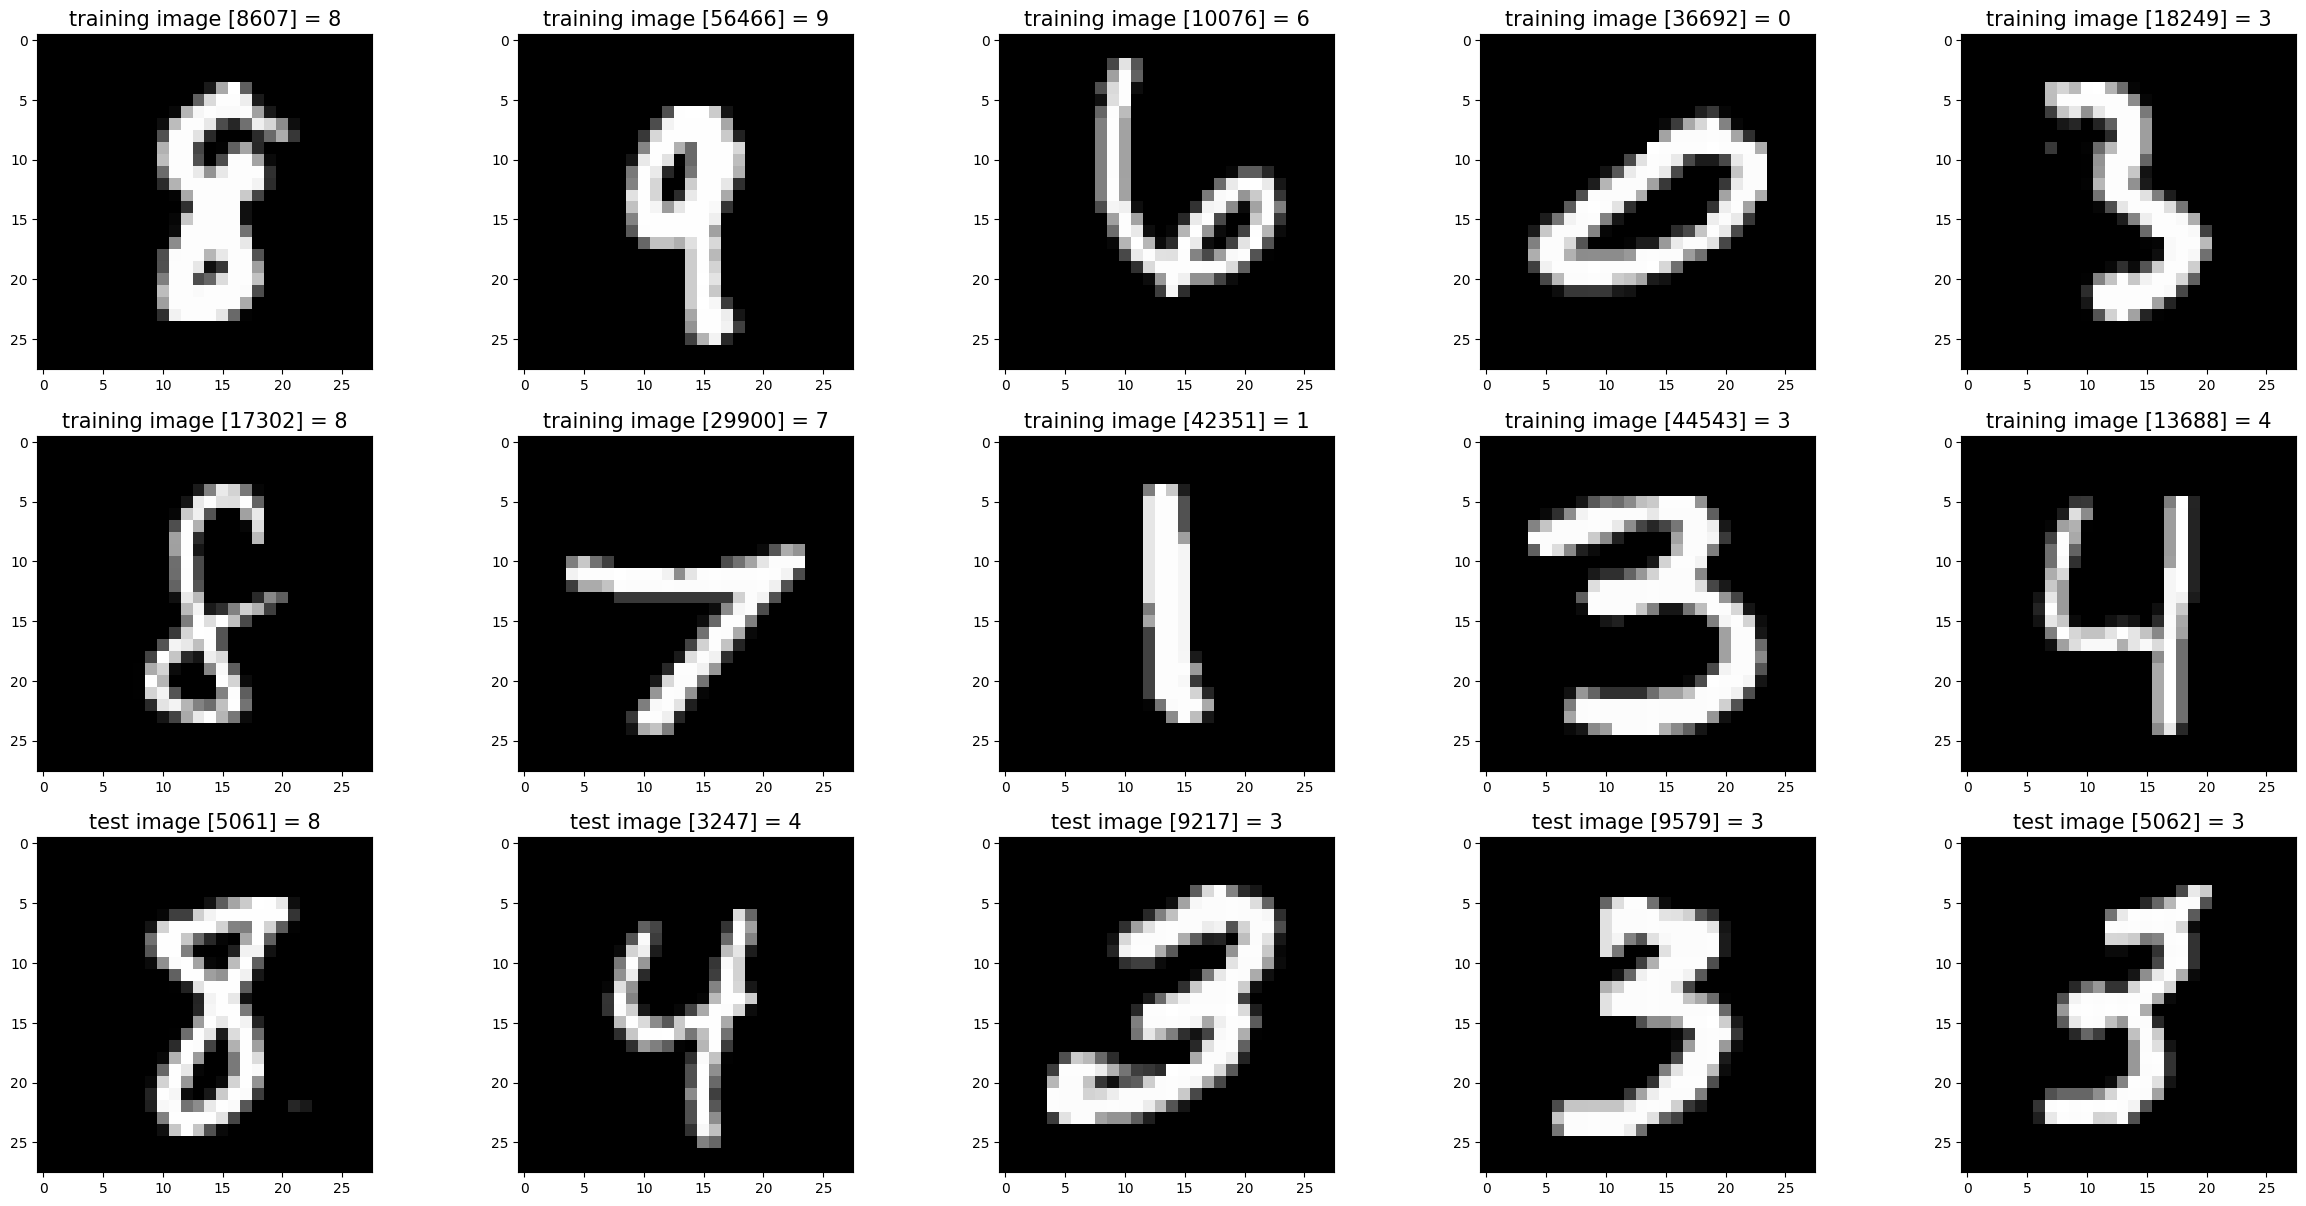

In [159]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '/Users/dhruvgupta/Documents/AI_Learning/Andrew_Ng_Coursera/MNIST-Dataset/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Analyse Data-set

Look at shape and properties of x_train data

In [160]:
#Look at the structure of the training data
print(x_train[0])

#convert to a Numpy array
x_train = np.array(x_train)
X = x_train #save variable for use later

#Look at dimensions of data
print(f'The data has {x_train.shape} dimensions')

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
        18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
         0,   0], dtype=uint8), array([  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
       253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
         0,   0], dtype=uint8), array([  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
       253

Turn each row from a 28 x 28 array into a 1 x 784 array

In [161]:
#Convert data so it can be fed into a Neural Net
x_train = x_train.reshape(x_train.shape[0],-1) # for a 3d array

print(f'Formatted data has dimensions {x_train.shape}')
print(x_train[0])

Formatted data has dimensions (60000, 784)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253

Investigate labels: y_train

In [162]:
#Convert data to a Numpy array
y_train=np.array(y_train)

#convert into 2-D (matrix) 
y_train = np.expand_dims(y_train, axis=1)

print(f'Output data has dimensions {y_train.shape}')
print(f'The first digit is a {y_train[0]}')
print(f'There are {np.sum(y_train ==9)} number 9s')

Output data has dimensions (60000, 1)
The first digit is a [5]
There are 5949 number 9s


## Create / Fit Neural Network

Fit Model - using softmax as final layer not "Linear"

In [165]:
#Define number of parameters for input layer
input_size = x_train.shape[1]

model = Sequential([
    tf.keras.Input(shape=(input_size,)), # without this line - does not build parameters as there is no input
    Dense(units = 25, activation = 'relu',name='L1'),
    Dense(units = 15, activation = 'relu',name='L2'),
    Dense(units=10, activation = 'softmax',name='L3')
],
name = "my_model" )

model.compile(loss=SparseCategoricalCrossentropy(), #from_logits=True
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)) # This is super important



View model Parameters and Size

In [166]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 25)             │        19,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,175 (78.81 KB)

 Trainable params: 20,175 (78.81 KB)

 Non-trainable params: 0 (0.00 B)

Examine the size of the layers

In [167]:
[layer1, layer2, layer3] = model.layers

#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


Run model fitting - save to history to plot Cost vs Interations

In [168]:
history = model.fit(x_train,y_train,epochs=20)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step - loss: 3.6896
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 0.7400
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step - loss: 0.5777
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - loss: 0.5043
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 0.4687
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 0.4298
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - loss: 0.3846
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - loss: 0.3431
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - loss: 0.3101
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - loss: 0.2952
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 0.2831
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step - loss: 0.2725
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 0.2672
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 0.2588
E

Plot Cost vs Iterations

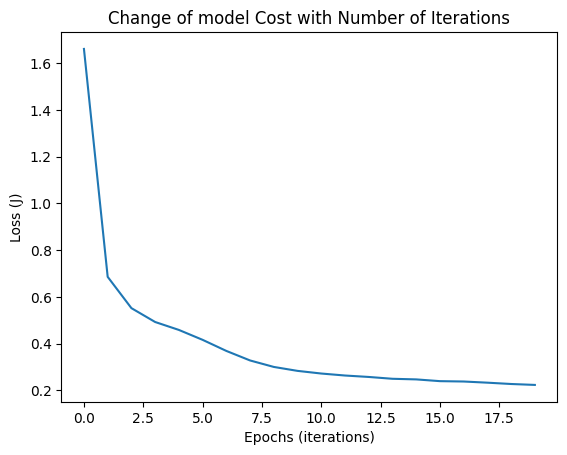

In [169]:
#print(history.history.keys())
#print(history.history['loss'])

plt.plot(history.history['loss'])
plt.xlabel('Epochs (iterations)')
plt.ylabel('Loss (J)')
plt.title('Change of model Cost with Number of Iterations')
plt.show()

Predict Values based on model

In [171]:
#Test model accuracy on training data
y_hat = model.predict(x_train)

print(f'The dimnesions of the model prediction are: {y_hat.shape}')
print(y_hat[1])



1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step
The dimnesions of the model prediction are: (60000, 10)
[9.9999845e-01 1.3098987e-14 1.3527472e-08 2.0801590e-07 5.7813260e-08
 2.9674342e-07 7.1723374e-09 7.5297424e-10 6.5357930e-10 1.0308771e-06]


Apply Classification Threshold

In [173]:
#Define digit as value that is greater than 0.5
predictions = np.where(y_hat >= 0.5, 1, 0)

print('The ouput of the first digit is:')
print(predictions[0])

The ouput of the first digit is:
[0 0 0 1 0 0 0 0 0 0]


Convert back from one-hot matrix

In [174]:

digit = np.argmax(predictions[0])
prediction_digit = np.argmax(predictions, axis=1)
print(prediction_digit.shape)

(60000,)


### Calculate Accuracy on Training Set

In [175]:
y = y_train.reshape(-1)
print(y.shape)
#diff = prediction_digit - y_train
#print(diff[0:10])

errors = np.where(y != prediction_digit)

print(errors[0])

y_wrong = y[errors]

print(y_wrong.shape)

yhat_wrong = prediction_digit[errors]

print(y_wrong[0:10])
print(yhat_wrong[0:10])


(60000,)
[    0    25    28 ... 59915 59928 59948]
(4525,)
[5 2 2 8 9 4 8 9 8 2]
[3 3 7 2 3 7 0 0 3 7]


Accuracy %

In [176]:
accuracy =(( len(y) - len(y_wrong) )/ len(y) ) * 100

print(accuracy)

92.45833333333333


Inspect some incorrect digits

In [143]:
missclassified = len(y_wrong)
error_indicies = errors[0]

X = np.array(X)
print(X.shape)
X_wrong = X[error_indicies]

print(X_wrong.shape)


(60000, 28, 28)
(2382, 28, 28)


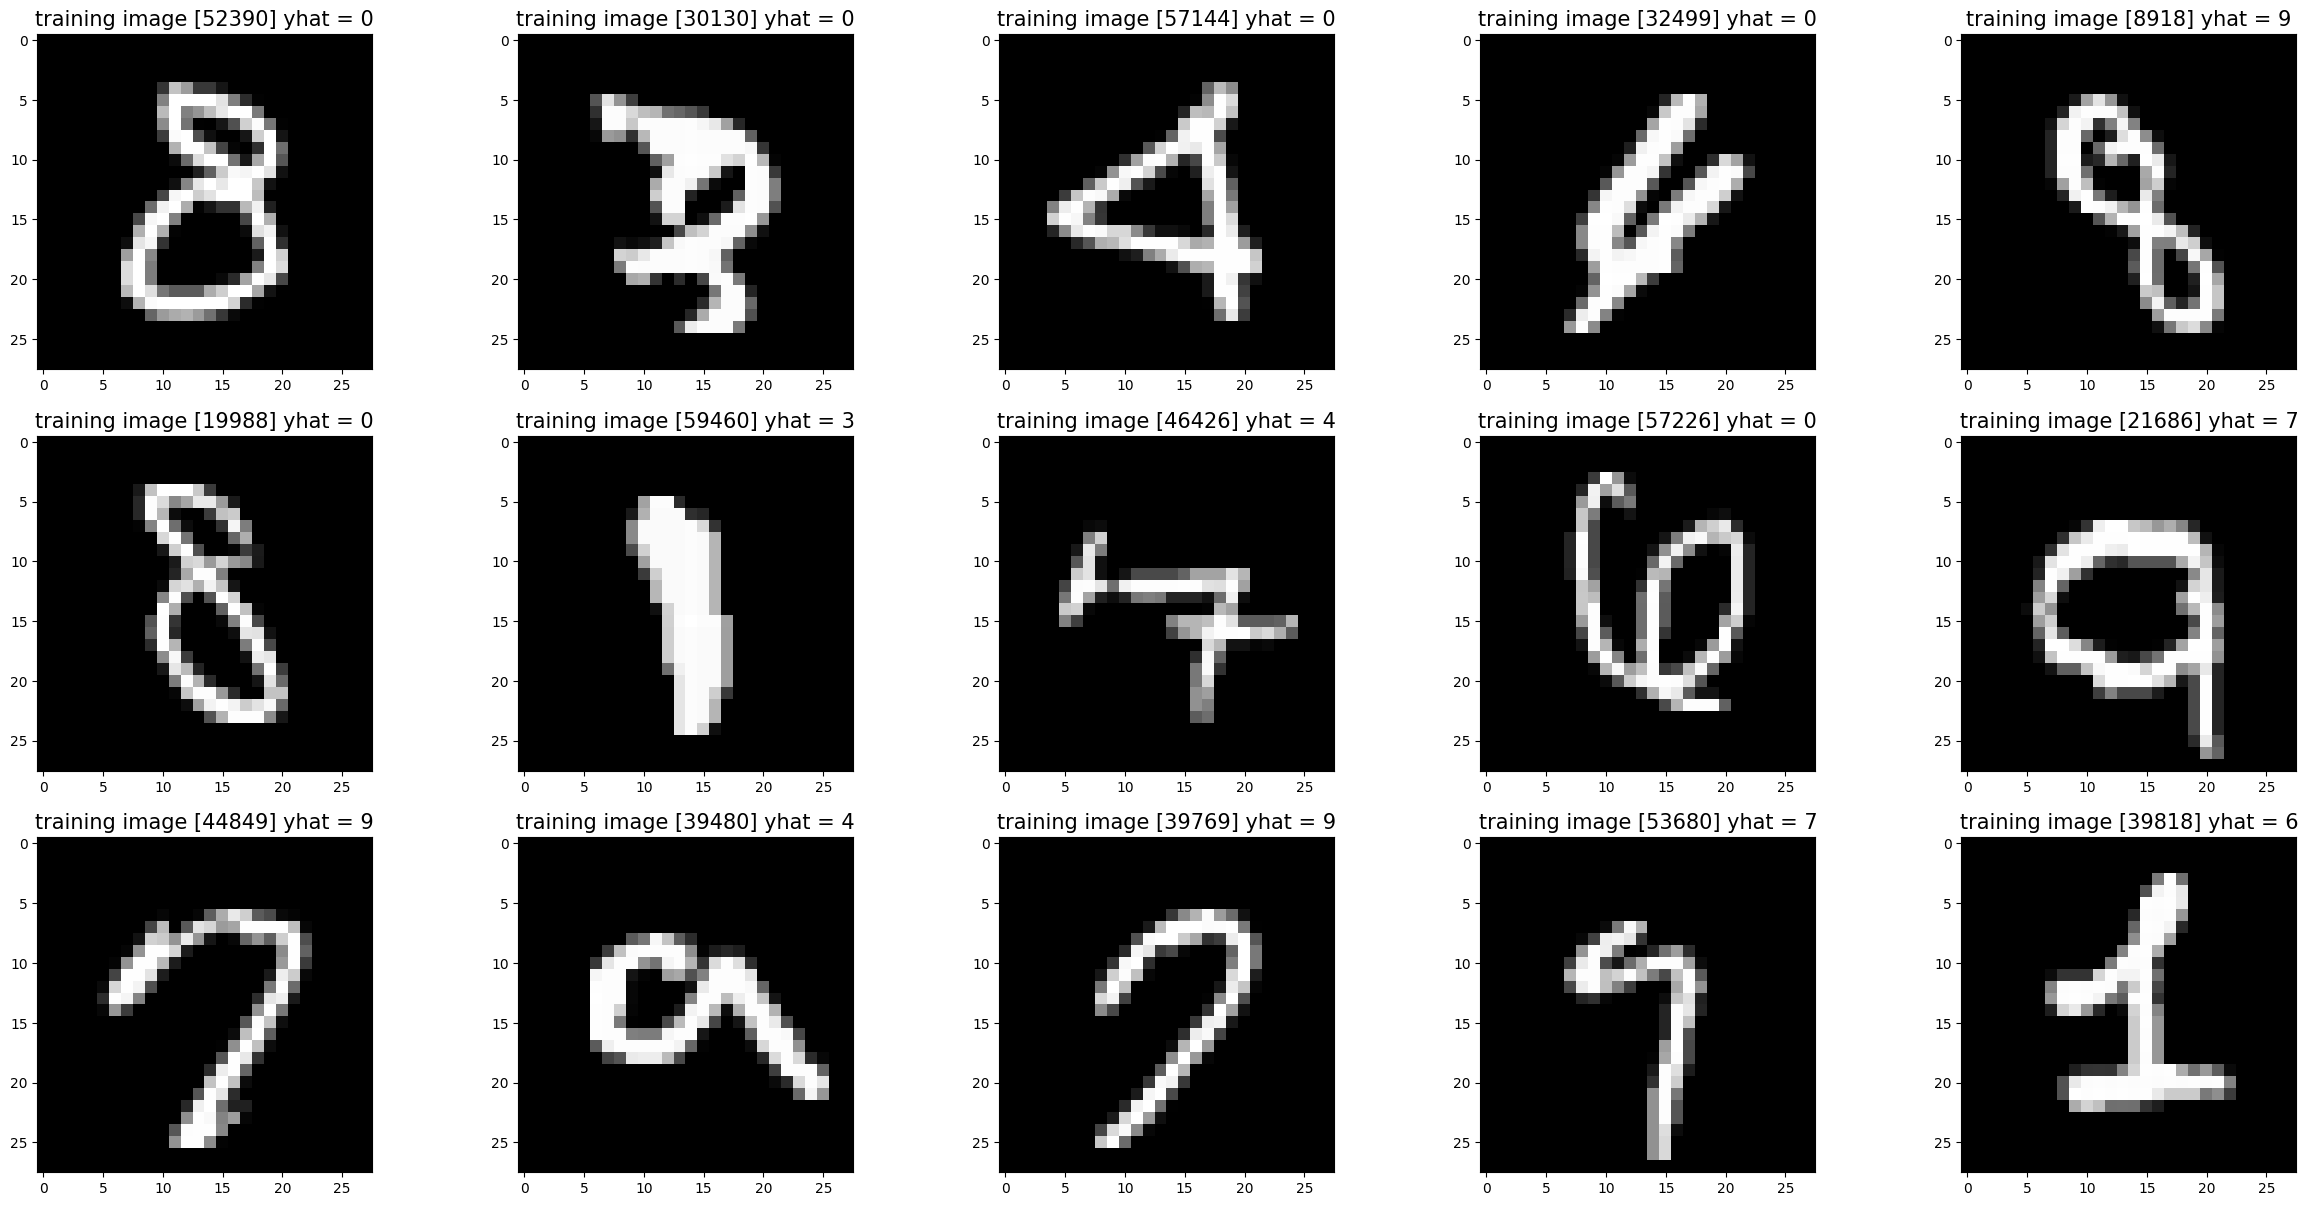

In [144]:
images_wrong_show = []
titles_wrong_show = []
for i in range(0, 10):
    r = random.randint(1, missclassified)
    images_wrong_show.append(X_wrong[r])
    titles_wrong_show.append('training image [' + str(error_indicies[r]) + '] yhat = ' + str(yhat_wrong[r]))    

for i in range(0, 5):
    r = random.randint(1, missclassified)
    images_wrong_show.append(X_wrong[r])        
    titles_wrong_show.append('training image [' + str(error_indicies[r]) + '] yhat = ' + str(yhat_wrong[r]))    

show_images(images_wrong_show, titles_wrong_show)

Function of predicting Accuracy of Model

Adjust Classification Threshold to plot AOC